# Get and interpret StackOverflow jobs data
Just curious whether the distribution of interests in the DuPage Python meetup group mirrors the distribution of job opportunities. (Spoiler alert: it doesn't; at least the Stackoverflow jobs snapshot here was frontend-heavy and that's the smallest category of interest among us. Booooo.) It is surprising to me how many director/manager jobs are listed. (I lumped project managers into this group too out of laziness for this notebook--so beware.)

### Side note
For my own long-term employment I like to keep an eye on what skills and roles are in demand. Taking multiple snapshots like this over the year can give a sense of when companies like to hire, and for what. For example, although there are zero Data Science roles listed here in Chicago, the GitHub listing (which only had two Chicago roles so I did the whole US) had about 20; so regional variation and your geographic preferences may be worth considering.

## Setup

In [0]:
!pip install --quiet upsetplot

import json
import re

import pandas
import requests
# Here is the R version of upsetplot (from the original authors)
#   https://cran.r-project.org/web/packages/UpSetR/vignettes/basic.usage.html
import upsetplot
from collections import Counter, namedtuple
from lxml import etree

## Get the data

The Stackoverflow Jobs API is actually just an RSS feed ([stackexchange question](https://meta.stackexchange.com/a/158221/289453)). The linked response has a direct link to their RSS feed, like this: [https://stackoverflow.com/jobs/feed?q=python&l=chicago](https://stackoverflow.com/jobs/feed?q=python&l=chicago) that shows how to structure the URL to filter for location and a query term.


If you click on the feed link, you can tell the response is in XML, so you have to parse it, which is why there is so much code below. To build up these search functions and namespaces, etc, there's no way around it but to look at the actual feed at first and figure out what on earth is in it...

### Set up to pull data

In [0]:
stackoverflow_url = "https://stackoverflow.com/jobs/feed?l=chicago&u=Miles&d=50"
namespaces = dict(
    w3="http://www.w3.org/2005/Atom",
    so="http://stackoverflow.com/jobs/",
)

# I got this by looking at the raw HTML first to realize
# - The data are grouped under `//item`
# - Each item has the following components:
# - (and the `category` item has multiple entries)
Row = namedtuple("Row", [
    "author",
    "category",
    "description",
    "guid",
    "link",
    "location",
    "pub_date",
    "title",
    "updated",
])


TitleData = namedtuple("TitleData", ["role", "company", "city", "state", "original"])

def title_to_role_company_city_state(
        element,
        pattern=re.compile(r"""
            (?P<role>.*)\s+at\s+    # {role} at {company}
            (?P<company>[^\(]*)\s+  # Assume no company name has parentheses
            \((?P<city>[^\)]*),\s+  # Hopefully no city has a comma or ')'
            (?P<state>\S+)\)        # Any consecutive nonspace is the state
       """, re.X)):
    title = element.findtext("title")
    # title --> "{role} at {company} ({city}, {state})"
    #match = pattern.fullmatch(title)
    match = pattern.match(title)
    if match and len(match.groups()) >= 4:
        arguments = list(match.groups()[:4]) + [title]
        return TitleData(*arguments)
    else:
        print(f"Didn't match {title} so returning a tuple of Nones")
        return TitleData(*([None] * 4 + [title]))


functions = Row(
    author=lambda e: e.findtext("w3:author", namespaces=namespaces),
    category=lambda elem: [e.text for e in elem.findall("category")],
    description=lambda e: e.findtext("description"),
    guid=lambda e: e.findtext("guid"),
    link=lambda e: e.findtext("link"),
    location=lambda e: e.findtext("so:location", namespaces=namespaces),
    pub_date=lambda e: e.findtext("pubDate"),
    title=title_to_role_company_city_state,
    updated=lambda e: e.findtext("w3:updated", namespaces=namespaces)
)

### Actually pull data now

Here's a neat trick for similarly structured data like these XML elements: because the `functions` variable is an actual `Row` object with all the same names, I can do this trick below with the `Row(*(f(element) for f in functions))`  to create each new row by going through each element in the XML path and extracting what I need.

Then the Counter lets us see quickly what the top 10 in each category of interest is.

In [0]:
response = requests.get(stackoverflow_url)
root = etree.fromstring(response.content)
items = root.xpath("//item")
data = []
for element in items:
    data.append(Row(*(f(element) for f in functions)))

# That was it! The above pulled and transformed all the data!
    
    
    
print("Top 10 locations (shouldn't be a surprise...Chicago)")
print(Counter(d.location for d in data).most_common(10))

print("\nTop 10 companies")
print(Counter(d.title.company for d in data).most_common(10))

print("\nTop 10 categories")
# Nested data so I have to do the multiple "for" thing
print(Counter(c for d in data for c in d.category).most_common(10))

print("\nTop 10 roles")
print(Counter(d.title.role for d in data).most_common(10))

print("\nTop 10 *Python* roles")
print(Counter(d.title.role for d in data if "python" in d.category).most_common(10))

Top 10 locations (shouldn't be a surprise...Chicago)
[('Chicago, IL', 80), ('Pleasant Prairie, WI', 6), ('Riverwoods, IL', 5), ('Oakbrook Terrace, IL', 2), ('Schaumburg, IL', 2), ('Buffalo Grove, IL', 2), ('Glen Ellyn, IL', 1), ('Evanston, IL', 1), ('Fox River Grove, IL', 1), ('Rolling Meadows, IL', 1)]

Top 10 companies
[('JP Morgan Chase', 26), ('Uline', 6), ('Discover', 5), ('NextCapital', 4), ('Solstice', 3), ('Critical Mass', 3), ('Bridge Financial Technology', 3), ('DRW', 3), ('Vivid Seats LLC', 3), ('Akuna Capital', 3)]

Top 10 categories
[('java', 45), ('python', 44), ('sql', 32), ('javascript', 22), ('amazon-web-services', 15), ('linux', 11), ('c++', 8), ('sysadmin', 8), ('reactjs', 8), ('automation', 6)]

Top 10 roles
[('Senior Software Engineer', 7), ('Software Engineer', 3), ('Lead Software Engineer - Java /J2EE & Oracle', 2), ('Site Reliability Engineer', 2), ('Java Software Engineer', 2), ('Software Engineering - Full Stack Developer (Java)', 2), ('Data Engineer', 2), ('D

#### Observations
- Python is now a kind of ubiquitous add-on requirement, it seems
- The category tags sometimes don't seem to match the job title (e.g. Python + SQL tags --> "Java Software Engineer - Oracle, and AngularJS" whaa?)

### Look at the job roles more

The `levels` regex will try to peel off the modifiers to the titles, and all the `roles` are regex patterns for specific terms related to the role. Note that a manager of a division and a "project manager" both match the "managers" group; I did not want to work to separate them. Some things, like putting "sql" in with "backend" may have inflated the backend numbers, since pretty much everyone should know SQL. More careful reading of examples would help inform choices like this, but I'm doing all this analysis for one slide in a January meetup talk, so I'm allowed to not be as careful as I could be.

In [0]:
levels = re.compile("(senior|junior|sr.|jr.|lead) ?", re.IGNORECASE)
roles = [
    ("managers", re.compile("(manager|director)", re.IGNORECASE)),
    ("ops", re.compile("dev.?ops", re.IGNORECASE)),
    ("full stack", re.compile("full.?stack", re.IGNORECASE)),
    ("front end", re.compile("(front.?end|php)", re.IGNORECASE)),
    ("backend", re.compile("(back.?end|sql)", re.IGNORECASE)),
    ("quality", re.compile("(q.?a|quality.a)", re.IGNORECASE)),
    ("security", re.compile("(security|devsec|opsec)", re.IGNORECASE)),
    ("data science", re.compile("data.?scien", re.IGNORECASE)),
    ("other dev", re.compile(".*", re.IGNORECASE)),
]

by_roles = {k:[] for k,v in roles}
for d in data:
    role = next(role for role, regex in roles if regex.search(d.title.role) or regex.search(d.description))
    by_roles[role].append(d)
    
    
print(f"{len(data)} total Stackoverflow jobs")

for role, jobs in by_roles.items():
     print(f"{role}: {len(jobs)} jobs  ({len(jobs) / len(data):.0%})")
        
print()
print("*" * 20)
#Counter(levels.sub("", d.title.role).rsplit(" - ", 1)[0] for d in data).most_common()
Counter(levels.sub("", d.title.role) for d in data).most_common()

103 total Stackoverflow jobs
managers: 30 jobs  (29%)
ops: 10 jobs  (10%)
full stack: 7 jobs  (7%)
front end: 11 jobs  (11%)
backend: 18 jobs  (17%)
quality: 21 jobs  (20%)
security: 2 jobs  (2%)
data science: 0 jobs  (0%)
other dev: 4 jobs  (4%)

********************


[('Software Engineer', 11),
 ('DevOps Engineer', 4),
 ('Data Engineer', 3),
 ('Software Engineer - Java /J2EE & Oracle', 2),
 ('Site Reliability Engineer', 2),
 ('Software Developer', 2),
 ('Java Software Engineer', 2),
 ('Software Engineering - Full Stack Developer (Java)', 2),
 ('Software Architect', 2),
 ('Network Engineer', 2),
 ('Java Software Engineer- Oracle, and AngularJS', 1),
 ('C++ eTrading Software Engineer', 1),
 ('Java Developer', 1),
 ('Java Software Engineering', 1),
 ('Full Time Faculty - Computer Information Systems', 1),
 ('Information Technology Manager/Admin Coordinator (Windows/Linux Systems Engineer at University of Illinois',
  1),
 ('Fullstack Java Software Engineer', 1),
 ('Java/J2EE Software Engineer', 1),
 ('Front-end React Redux Developer', 1),
 ('Product Manager', 1),
 ('Education Construction Project Manager', 1),
 ('Data Cloud Architect', 1),
 ('C++ Software Developer (Quantitative Trading Firm)', 1),
 ('Software Engineer - Java / J2EE & Oracle', 1),
 ('

### Make a data frame with only the top 10 categories, just to see

In [0]:
top10_categories = [cat for (cat, ct) in Counter(c for d in data for c in d.category).most_common(10)]
subsets = []
for row in data:
    subsets.append(dict(
        role=row.title.role,
        company=row.title.company,
    ))
    subsets[-1].update({k:(k in row.category) for k in top10_categories})

df = pandas.DataFrame(subsets)
df[["company"] + top10_categories].groupby("company").sum().sort_values(top10_categories, ascending=False).head(7)

,java,python,sql,javascript,amazon-web-services,linux,c++,sysadmin,reactjs,automation
company,,,,,,,,,,
JP Morgan Chase,26.0,26.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Discover,4.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
DRW,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
Critical Mass,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Uline,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
Gogo,1.0,2.0,0.0,1.0,2.0,1.0,0.0,3.0,0.0,1.0
Label Insight,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### JP Morgan Chase's 2019 hiring bunch is overwhelming all of the other data

They need javascript and other devs based on the job titles, so that's what tipped me off to not 100% trusting the categories they used. From reading their descriptions, Java is the primary language, and Python is just a necessary secondary. There's another company in Chicago who hosted a ChiPy meetup that uses Python pretty much only to unit-test its Java code, which is a little sad, but props to people using the thing that works best for their need.

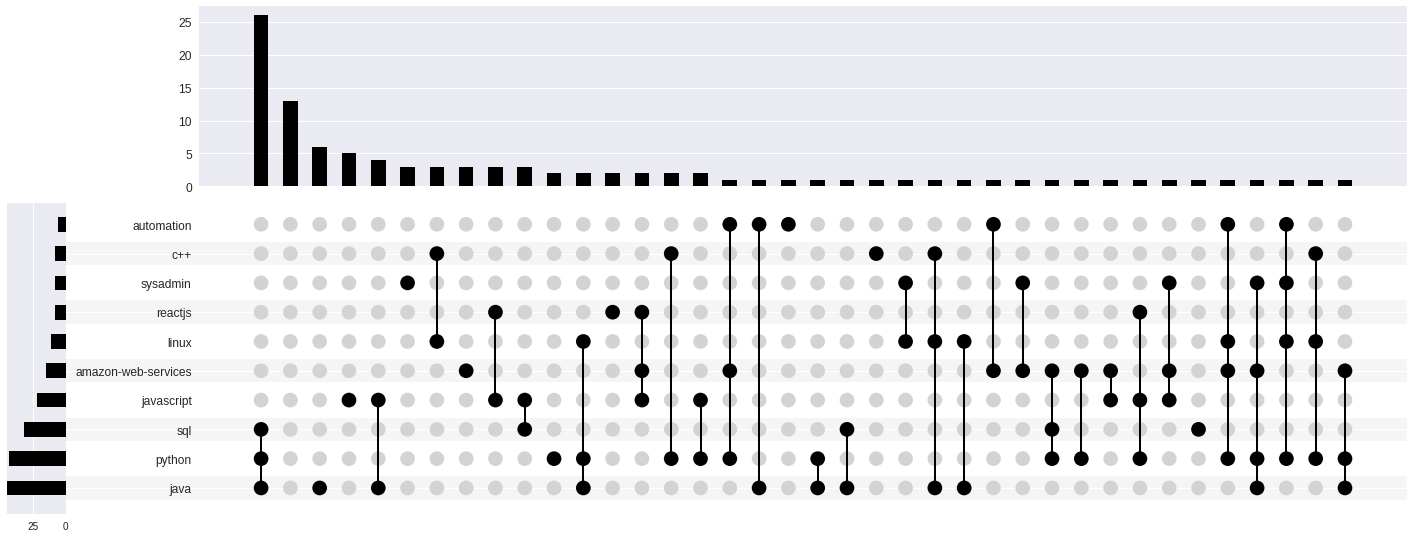

In [0]:
stackoverflow_sets = (
    df[top10_categories + ["role"]]
    .fillna(False)
    .groupby(top10_categories)
    .count()
)
p = upsetplot.plot(
    stackoverflow_sets["role"],
    element_size=42,  # point size of "side of element"
    sort_by="cardinality",
);

p['intersections'].tick_params(labelsize="medium")
p['matrix'].tick_params(labelsize="medium")
#import matplotlib
#from google.colab import files
#current_figure = matplotlib.pyplot.gcf()
#current_figure.savefig("stackoverflow_sets.png")
#files.download("stackoverflow_sets.png")


#### Show the table that made the chart above

In [0]:
stackoverflow_sets["role"]

java   python  sql    javascript  amazon-web-services  linux  c++    sysadmin  reactjs  automation
False  False   False  False       False                False  False  False     False    False         13
                                                                                        True           1
                                                                               True     False          2
                                                                     True      False    False          3
                                                              True   False     False    False          1
                                                       True   False  True      False    False          1
                                                              True   False     False    False          3
                                  True                 False  False  False     False    False          3
                                                             

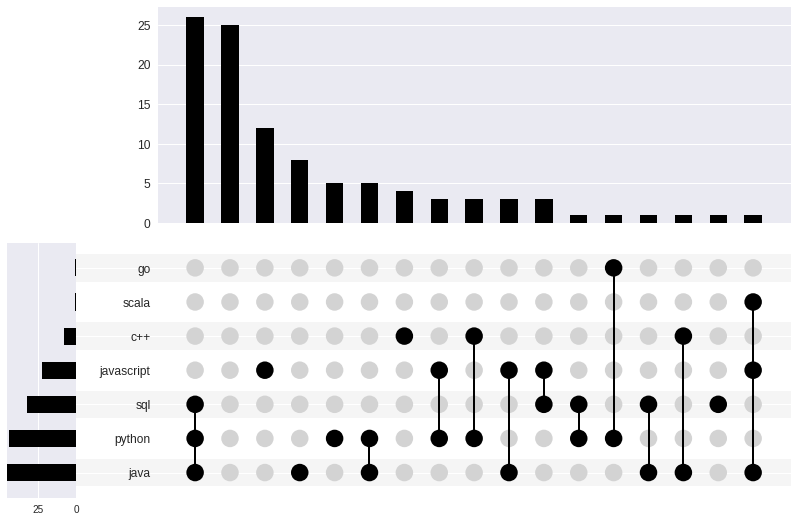

In [0]:
# Again but this time only do programming languages
language_categories = ['python', 'java', 'sql', 'javascript', 'c++', 'go', 'scala']
subsets = []
for row in data:
    subsets.append(dict(
        role=row.title.role,
        company=row.title.company,
    ))
    subsets[-1].update({k:(k in row.category) for k in language_categories})

df = pandas.DataFrame(subsets)


stackoverflow_sets = (
    df[language_categories + ["role"]]
    .fillna(False)
    .groupby(language_categories)
    .count()
)
p = upsetplot.plot(
    stackoverflow_sets["role"],
    element_size=50,  # point size of "side of element"
    sort_by="cardinality",
);

p['intersections'].tick_params(labelsize="medium")
p['matrix'].tick_params(labelsize="medium")
import matplotlib
from google.colab import files
current_figure = matplotlib.pyplot.gcf()
current_figure.savefig("stackoverflow_sets_languages_only.png")
files.download("stackoverflow_sets_languages_only.png")

#### Show the table that made the chart above

In [0]:
stackoverflow_sets["role"]

python  java   sql    javascript  c++    go     scala
False   False  False  False       False  False  False    25
                                  True   False  False     4
                      True        False  False  False    12
               True   False       False  False  False     1
                      True        False  False  False     3
        True   False  False       False  False  False     8
                                  True   False  False     1
                      True        False  False  False     3
                                                True      1
               True   False       False  False  False     1
True    False  False  False       False  False  False     5
                                         True   False     1
                                  True   False  False     3
                      True        False  False  False     3
               True   False       False  False  False     1
        True   False  False       False  False

## Observations

- JP Morgan Chase's data dominate the StackOverflow set, but it looks like you double your job options if you add Java to your repertoire.
- Python and Java were the top two tagged language; for each almost 50% of opportunities wanted at least one.
- Python and javascript is front end of course
- Python and Scala for Spark I guess
- Python and C++ for trading
- Surprising to see literally zero Data Science jobs...good to know

So there's where we are.

#### Caveat
This was a cursory look at a single day of data in the depths of the holiday season. Who knows whether it's an outlier or the norm? To understand the market and our prospects in it we'd really need to do this multiple times per year.

# MOAR!

## GitHub API

The GitHub jobs API analysis was so small that I'm just tacking it on to the StackOverflow one.
I only found 2 Chicago jobs (and 2 Illinois!) posted on GitHub, so i expanded to the whole U.S.

In [43]:
import json
import requests

i = 0
results = []
while True:
    url = f"https://jobs.github.com/positions.json?&location=usa&page={i}"
    i = i + 1
    try:
        data = requests.get(url).json()
        results.extend(data)
    except json.decoder.JSONDecodeError:
        data = []
    if len(data) < 50 or len(results) > 1000:
        break  # Finished all pulls
        
print(f"Pulled {len(results)} positions.")

Pulled 182 positions.


### Same patterns but pasted again
In case people don't want to scroll all the way up to get them.

In [44]:
import re

roles = [
    ("managers", re.compile("(manager|director)", re.IGNORECASE)),
    ("ops", re.compile("dev.?ops", re.IGNORECASE)),
    ("full stack", re.compile("full.?stack", re.IGNORECASE)),
    ("front end", re.compile("(front.?end|php)", re.IGNORECASE)),
    ("backend", re.compile("(back.?end|sql)", re.IGNORECASE)),
    ("architect", re.compile("architect", re.IGNORECASE)),
    ("quality", re.compile("(q.?a|quality.a)", re.IGNORECASE)),
    ("security", re.compile("(security|dev.?sec|op.?sec)", re.IGNORECASE)),
    ("data science", re.compile("data.?scien", re.IGNORECASE)),
    ("other dev", re.compile(".*", re.IGNORECASE)),
]


by_roles = {k:[] for k,v in roles}
for r in results:
    role = next(role for role, regex in roles if regex.search(r['description']))
    by_roles[role].append(r)
    
    
print(f"{len(results)} total GitHub jobs")

for role, jobs in by_roles.items():
     print(f"{role}: {len(jobs)} jobs  ({len(jobs) / len(results):.0%})")
      
print()
print("*" * 20)
print("LANGUAGES")
    
for language in ("javascript", "python", "sql", "java", "c++", "scala"):
    if language == "java":
        total_jobs = len([r for r in results if language in r['description'].lower() and not "javascript" in r['description'].lower()])
    else:
        total_jobs = len([r for r in results if language in r['description'].lower()])
    print(f"{language}: {total_jobs} jobs ({total_jobs / len(results):.0%})")


182 total GitHub jobs
managers: 37 jobs  (20%)
ops: 17 jobs  (9%)
full stack: 25 jobs  (14%)
front end: 24 jobs  (13%)
backend: 19 jobs  (10%)
architect: 17 jobs  (9%)
quality: 32 jobs  (18%)
security: 1 jobs  (1%)
data science: 0 jobs  (0%)
other dev: 10 jobs  (5%)

********************
LANGUAGES
javascript: 65 jobs (36%)
python: 66 jobs (36%)
sql: 58 jobs (32%)
java: 25 jobs (14%)
c++: 18 jobs (10%)
scala: 47 jobs (26%)


# Library versions

In [52]:
import datetime
import sys

import lxml
import matplotlib
import pandas
import requests
import upsetplot

print(f"""
Date: {datetime.date.today()}
Python {sys.version}
Libraries:
- lxml {lxml.etree.LXML_VERSION}
- matplotlib {matplotlib.__version__}
- pandas {pandas.__version__}
- requests {requests.__version__}
- upsetplot {upsetplot.__version__}
""")


Date: 2019-01-01
Python 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
Libraries:
- lxml (4, 2, 5, 0)
- matplotlib 2.1.2
- pandas 0.22.0
- requests 2.18.4
- upsetplot 0.1

